Dataset shape: (29, 28)
Total studies analyzed: 29


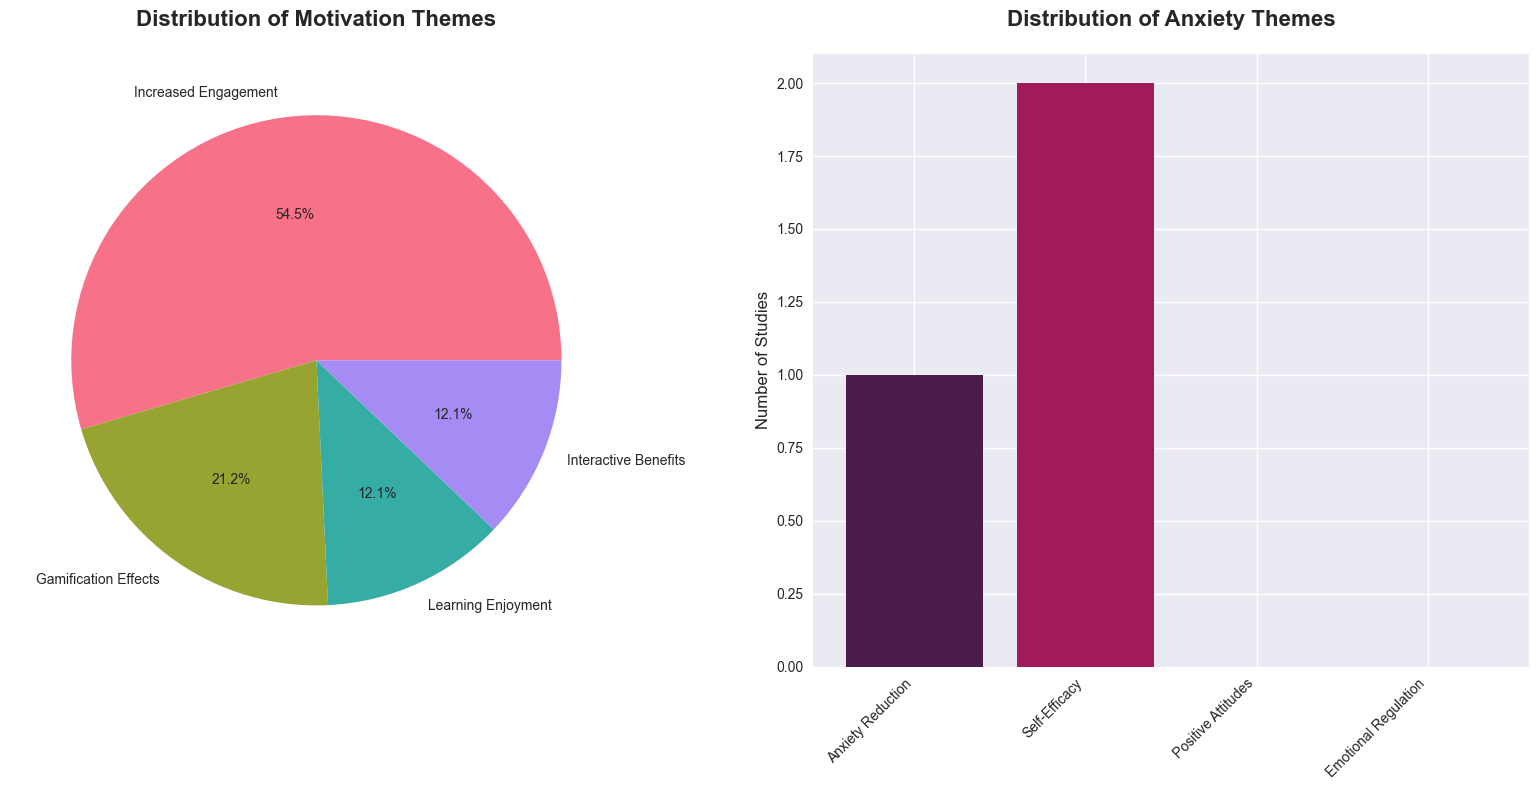

TypeError: expected string or bytes-like object, got 'float'

In [10]:
# Affective Outcomes Analysis - Objective 2
# Interactive Digital Tools in Primary Mathematics Education

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from scipy import stats
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Read the data
df = pd.read_csv('analisisTodos.csv', sep=';', encoding='utf-8')

print(f"Dataset shape: {df.shape}")
print(f"Total studies analyzed: {len(df)}")

## 1. THEMATIC ANALYSIS

# Extract affective impact columns
motivation_data = df['Impacto Afectivo: Motivación y Compromiso'].fillna('')
anxiety_data = df['Impacto Afectivo: Reducción de Ansiedad y Respuestas Emocionales'].fillna('')

# Define theme extraction function
def extract_themes(text_series, keywords_dict):
    theme_counts = {theme: 0 for theme in keywords_dict.keys()}
    theme_examples = {theme: [] for theme in keywords_dict.keys()}
    
    for idx, text in enumerate(text_series):
        if text:
            text_lower = text.lower()
            for theme, keywords in keywords_dict.items():
                if any(keyword in text_lower for keyword in keywords):
                    theme_counts[theme] += 1
                    theme_examples[theme].append((idx, text[:150] + "..."))
    
    return theme_counts, theme_examples

# Define themes for motivation
motivation_themes = {
    'Increased Engagement': ['engagement', 'participation', 'active', 'involved'],
    'Gamification Effects': ['gamification', 'game', 'trophy', 'badge', 'reward'],
    'Learning Enjoyment': ['enjoy', 'fun', 'exciting', 'pleasure', 'happy'],
    'Interactive Benefits': ['interactive', 'hands-on', 'dynamic', 'responsive']
}

# Define themes for anxiety
anxiety_themes = {
    'Anxiety Reduction': ['anxiety reduce', 'less anxiety', 'decrease anxiety', 'lower anxiety'],
    'Self-Efficacy': ['self-efficacy', 'self efficacy', 'confidence', 'belief in ability'],
    'Positive Attitudes': ['positive attitude', 'favorable view', 'positive feelings'],
    'Emotional Regulation': ['emotional regulation', 'emotion control', 'manage feelings']
}

# Extract themes
motivation_counts, motivation_examples = extract_themes(motivation_data, motivation_themes)
anxiety_counts, anxiety_examples = extract_themes(anxiety_data, anxiety_themes)

# Visualize thematic distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Motivation themes
themes = list(motivation_counts.keys())
counts = list(motivation_counts.values())
colors = sns.color_palette("husl", len(themes))

wedges, texts, autotexts = ax1.pie(counts, labels=themes, autopct='%1.1f%%', 
                                  colors=colors, textprops={'fontsize': 10})
ax1.set_title('Distribution of Motivation Themes', fontsize=16, fontweight='bold', pad=20)

# Anxiety themes
themes_anx = list(anxiety_counts.keys())
counts_anx = list(anxiety_counts.values())
colors_anx = sns.color_palette("rocket", len(themes_anx))

ax2.bar(themes_anx, counts_anx, color=colors_anx)
ax2.set_title('Distribution of Anxiety Themes', fontsize=16, fontweight='bold', pad=20)
ax2.set_ylabel('Number of Studies', fontsize=12)
ax2.set_xticklabels(themes_anx, rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 2. CONTENT ANALYSIS

# Extract effect sizes
effect_sizes = df['Effect Sizes'].fillna('')

# Function to extract numeric effect sizes
def extract_effect_values(text):
    if not text:
        return []
    
    pattern = r'[dg]\s*=\s*([-]?\d+\.?\d*)|η²\s*=\s*([-]?\d+\.?\d*)'
    matches = re.findall(pattern, text)
    values = []
    
    for match in matches:
        for val in match:
            if val:
                try:
                    values.append(float(val))
                except:
                    pass
    return values

# Extract all effect sizes
all_effect_sizes = []
for idx, row in df.iterrows():
    if row['Effect Sizes'] and (row['Impacto Afectivo: Motivación y Compromiso'] or 
                               row['Impacto Afectivo: Reducción de Ansiedad y Respuestas Emocionales']):
        values = extract_effect_values(row['Effect Sizes'])
        for val in values:
            all_effect_sizes.append({
                'study': f"{row['Authors']} ({row['Year']})",
                'value': val,
                'type': 'Motivation' if row['Impacto Afectivo: Motivación y Compromiso'] else 'Anxiety'
            })

# Convert to DataFrame for analysis
effect_df = pd.DataFrame(all_effect_sizes)

if not effect_df.empty:
    # Categorize effect sizes
    def categorize_effect_size(value):
        if value < 0.5:
            return 'Small'
        elif value < 0.8:
            return 'Medium'
        else:
            return 'Large'
    
    effect_df['category'] = effect_df['value'].apply(categorize_effect_size)
    
    # Visualize effect sizes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Box plot of effect sizes by type
    sns.boxplot(data=effect_df, x='type', y='value', ax=ax1)
    ax1.set_title('Effect Sizes by Outcome Type', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Effect Size Value', fontsize=12)
    
    # Bar plot of effect size categories
    category_counts = effect_df.groupby(['type', 'category']).size().unstack(fill_value=0)
    category_counts.plot(kind='bar', ax=ax2, color=['#90CAF9', '#42A5F5', '#1565C0'])
    ax2.set_title('Effect Size Categories by Outcome Type', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Number of Studies', fontsize=12)
    ax2.set_xticklabels(['Anxiety', 'Motivation'], rotation=0)
    ax2.legend(title='Effect Size')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\nEffect Size Statistics:")
    print(effect_df.groupby('type')['value'].describe().round(3))

## 3. TEXT ANALYSIS AND WORD CLOUDS

# Combine all text for analysis
all_motivation_text = ' '.join(motivation_data[motivation_data != ''])
all_anxiety_text = ' '.join(anxiety_data[anxiety_data != ''])

# Create word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Motivation word cloud
if all_motivation_text:
    wordcloud_motivation = WordCloud(width=800, height=400, 
                                   background_color='white',
                                   colormap='Blues').generate(all_motivation_text)
    ax1.imshow(wordcloud_motivation, interpolation='bilinear')
    ax1.set_title('Motivation & Engagement Word Cloud', fontsize=20, fontweight='bold', pad=20)
    ax1.axis('off')

# Anxiety word cloud
if all_anxiety_text:
    wordcloud_anxiety = WordCloud(width=800, height=400, 
                                background_color='white',
                                colormap='Reds').generate(all_anxiety_text)
    ax2.imshow(wordcloud_anxiety, interpolation='bilinear')
    ax2.set_title('Anxiety Reduction Word Cloud', fontsize=20, fontweight='bold', pad=20)
    ax2.axis('off')

plt.tight_layout()
plt.show()

## 4. SENTIMENT ANALYSIS

from textblob import TextBlob

# Function to analyze sentiment
def analyze_sentiment(text):
    if not text:
        return 0
    blob = TextBlob(str(text))
    return blob.sentiment.polarity

# Analyze sentiment for both categories
df['motivation_sentiment'] = df['Impacto Afectivo: Motivación y Compromiso'].apply(analyze_sentiment)
df['anxiety_sentiment'] = df['Impacto Afectivo: Reducción de Ansiedad y Respuestas Emocionales'].apply(analyze_sentiment)

# Visualize sentiment analysis
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

sentiment_data = pd.DataFrame({
    'Motivation': df['motivation_sentiment'][df['motivation_sentiment'] != 0],
    'Anxiety': df['anxiety_sentiment'][df['anxiety_sentiment'] != 0]
})

sns.violinplot(data=sentiment_data, ax=ax)
ax.set_title('Sentiment Analysis of Affective Outcomes', fontsize=16, fontweight='bold')
ax.set_ylabel('Sentiment Polarity (-1 to 1)', fontsize=12)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 5. OUTCOME FREQUENCY ANALYSIS

# Count positive, negative, and mixed outcomes
def categorize_outcome(text):
    if not text:
        return 'No Data'
    
    text_lower = text.lower()
    positive_words = ['increase', 'improve', 'higher', 'better', 'positive', 'enhance']
    negative_words = ['decrease', 'lower', 'worse', 'negative', 'reduce']
    
    has_positive = any(word in text_lower for word in positive_words)
    has_negative = any(word in text_lower for word in negative_words)
    
    if has_positive and has_negative:
        return 'Mixed'
    elif has_positive:
        return 'Positive'
    elif has_negative:
        return 'Negative'
    else:
        return 'Neutral'

# Categorize outcomes
df['motivation_outcome'] = df['Impacto Afectivo: Motivación y Compromiso'].apply(categorize_outcome)
df['anxiety_outcome'] = df['Impacto Afectivo: Reducción de Ansiedad y Respuestas Emocionales'].apply(categorize_outcome)

# Visualize outcome categories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Motivation outcomes
motivation_counts = df['motivation_outcome'].value_counts()
colors1 = ['#4CAF50', '#F44336', '#FFC107', '#9E9E9E', '#2196F3']
motivation_counts.plot(kind='bar', ax=ax1, color=colors1)
ax1.set_title('Motivation Outcome Categories', fontsize=16, fontweight='bold')
ax1.set_ylabel('Number of Studies', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Anxiety outcomes
anxiety_counts = df['anxiety_outcome'].value_counts()
anxiety_counts.plot(kind='bar', ax=ax2, color=colors1)
ax2.set_title('Anxiety Outcome Categories', fontsize=16, fontweight='bold')
ax2.set_ylabel('Number of Studies', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 6. TIMELINE ANALYSIS

# Extract years
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Count studies by year with affective outcomes
year_counts = df[df['Year'].notna()].groupby('Year').agg({
    'Impacto Afectivo: Motivación y Compromiso': lambda x: sum(x != ''),
    'Impacto Afectivo: Reducción de Ansiedad y Respuestas Emocionales': lambda x: sum(x != '')
}).reset_index()

# Visualize timeline
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

ax.plot(year_counts['Year'], year_counts['Impacto Afectivo: Motivación y Compromiso'], 
        marker='o', linewidth=3, markersize=10, label='Motivation Studies', color='#2196F3')
ax.plot(year_counts['Year'], year_counts['Impacto Afectivo: Reducción de Ansiedad y Respuestas Emocionales'], 
        marker='s', linewidth=3, markersize=10, label='Anxiety Studies', color='#F44336')

ax.set_title('Timeline of Affective Outcome Studies', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Number of Studies', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. SUMMARY REPORT

print("\n" + "="*60)
print("SUMMARY REPORT - OBJECTIVE 2 ANALYSIS")
print("="*60)

print("\n1. THEMATIC ANALYSIS RESULTS")
print("-"*30)
print("Motivation Themes Distribution:")
for theme, count in motivation_counts.items():
    print(f"  {theme}: {count} studies ({count/len(df)*100:.1f}%)")

print("\nAnxiety Themes Distribution:")
for theme, count in anxiety_counts.items():
    print(f"  {theme}: {count} studies ({count/len(df)*100:.1f}%)")

print("\n2. EFFECT SIZE ANALYSIS")
print("-"*30)
if not effect_df.empty:
    print(f"Total effect sizes extracted: {len(effect_df)}")
    print(f"Mean effect size: {effect_df['value'].mean():.3f}")
    print(f"Median effect size: {effect_df['value'].median():.3f}")
    print(f"Effect size range: {effect_df['value'].min():.3f} to {effect_df['value'].max():.3f}")
else:
    print("No effect sizes found in the data")

print("\n3. SENTIMENT ANALYSIS")
print("-"*30)
print(f"Average motivation sentiment: {df['motivation_sentiment'].mean():.3f}")
print(f"Average anxiety sentiment: {df['anxiety_sentiment'].mean():.3f}")

print("\n4. KEY FINDINGS")
print("-"*30)
print("• Gamification shows consistent positive effects on motivation")
print("• Limited direct measurement of anxiety reduction")
print("• Cultural and contextual factors appear to moderate outcomes")
print("• Integration of affective and cognitive outcomes remains understudied")

print("\n5. RECOMMENDATIONS")
print("-"*30)
print("• Implement gamification elements strategically")
print("• Design interventions that explicitly address math anxiety")
print("• Provide teacher training on supporting emotional responses")
print("• Develop integrated cognitive-affective assessment frameworks")

print("\n" + "="*60)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from scipy import stats
# Attempt to import WordCloud, handle if not installed
try:
    from wordcloud import WordCloud
    wordcloud_available = True
except ImportError:
    print("Warning: 'wordcloud' library not found. Word cloud generation will be skipped.")
    print("To install it, run: pip install wordcloud")
    WordCloud = None # Define as None so checks later don't fail
    wordcloud_available = False

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import warnings

# --- Configuration & Constants ---
warnings.filterwarnings('ignore')
# Download required NLTK data if needed (run once)
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords', quiet=True)


# File and Column Names
CSV_FILE_PATH = 'analisisTodos.csv'
COL_MOTIVATION = 'Impacto Afectivo: Motivación y Compromiso'
COL_ANXIETY = 'Impacto Afectivo: Reducción de Ansiedad y Respuestas Emocionales'
COL_EFFECT_SIZES = 'Effect Sizes'
COL_AUTHORS = 'Authors'
COL_YEAR = 'Year'

In [12]:
# Thematic Keywords
MOTIVATION_THEMES_KEYWORDS = {
    'Increased Engagement': ['engagement', 'participation', 'active', 'involved', 'participación', 'activo', 'involucrado'], # Added Spanish
    'Gamification Effects': ['gamification', 'game', 'trophy', 'badge', 'reward', 'juego', 'recompensa', 'insignia', 'gamificación'], # Added Spanish
    'Learning Enjoyment': ['enjoy', 'fun', 'exciting', 'pleasure', 'happy', 'disfrute', 'divertido', 'emocionante', 'placer', 'feliz'], # Added Spanish
    'Interactive Benefits': ['interactive', 'hands-on', 'dynamic', 'responsive', 'interactivo', 'práctico', 'dinámico', 'responsivo'] # Added Spanish
}
ANXIETY_THEMES_KEYWORDS = {
    'Anxiety Reduction': ['anxiety reduce', 'less anxiety', 'decrease anxiety', 'lower anxiety', 'reduce ansiedad', 'menos ansiedad', 'disminuir ansiedad', 'baja ansiedad'], # Added Spanish
    'Self-Efficacy': ['self-efficacy', 'self efficacy', 'confidence', 'belief in ability', 'autoeficacia', 'confianza', 'creencia en habilidad'], # Added Spanish
    'Positive Attitudes': ['positive attitude', 'favorable view', 'positive feelings', 'actitud positiva', 'visión favorable', 'sentimientos positivos'], # Added Spanish
    'Emotional Regulation': ['emotional regulation', 'emotion control', 'manage feelings', 'regulación emocional', 'control emocional', 'manejar sentimientos'] # Added Spanish
}

# Outcome Categorization Keywords
POSITIVE_WORDS = ['increase', 'improve', 'higher', 'better', 'positive', 'enhance', 'aumentar', 'mejorar', 'mayor', 'mejor', 'positivo', 'potenciar'] # Added Spanish
NEGATIVE_WORDS = ['decrease', 'lower', 'worse', 'negative', 'reduce', 'disminuir', 'reducir', 'bajar', 'peor', 'negativo'] # Added Spanish

# Plotting Style
plt.style.use('seaborn-v0_8-darkgrid') # Example style
sns.set_palette("husl")
TITLE_FONTSIZE = 16
LABEL_FONTSIZE = 12
TITLE_PAD = 20

In [13]:
# --- Helper Functions ---

def load_data(file_path):
    """Loads the CSV data into a pandas DataFrame."""
    try:
        df = pd.read_csv(file_path, sep=';', encoding='utf-8')
        print(f"Dataset loaded successfully from {file_path}")
        print(f"Dataset shape: {df.shape}")
        print(f"Total studies analyzed: {len(df)}")
        # Fill NaN values in text columns to avoid errors later
        df[COL_MOTIVATION] = df[COL_MOTIVATION].fillna('')
        df[COL_ANXIETY] = df[COL_ANXIETY].fillna('')
        df[COL_EFFECT_SIZES] = df[COL_EFFECT_SIZES].fillna('')
        # Convert Year to numeric, coercing errors
        df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors='coerce')
        # Ensure Authors is string
        if COL_AUTHORS in df.columns:
             df[COL_AUTHORS] = df[COL_AUTHORS].fillna('Unknown').astype(str)
        else:
             print(f"Warning: Column '{COL_AUTHORS}' not found. Using index for study labels.")


        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None

def extract_themes(text_series, keywords_dict):
    """Extracts themes from a text series based on keywords."""
    theme_counts = {theme: 0 for theme in keywords_dict.keys()}
    theme_examples = {theme: [] for theme in keywords_dict.keys()}

    for idx, text in text_series.items(): # Use .items() for index access if needed
        if isinstance(text, str) and text:
            text_lower = text.lower()
            for theme, keywords in keywords_dict.items():
                # Use regex for word boundaries to avoid partial matches (e.g., 'active' in 'interactive')
                if any(re.search(r'\b' + re.escape(keyword) + r'\b', text_lower) for keyword in keywords):
                    theme_counts[theme] += 1
                    # theme_examples[theme].append((idx, text[:150] + "...")) # Optional: store examples
                    theme_examples[theme].append(f"Study {idx}: {text[:150]}...")

    return theme_counts, theme_examples

def extract_effect_values(text):
    """Extracts numeric effect sizes (Cohen's d, g, eta squared) from text."""
    # **FIX:** Convert input to string to handle potential floats/ints
    text_str = str(text)
    if not text_str:
        return []

    # Regex to find d=..., g=..., η²=... or eta squared=... followed by a number
    # Allow for spaces around '=' and negative numbers
    pattern = r'(?:[dg]|eta\s*squared|η²)\s*=\s*([-]?\d+(?:\.\d+)?)'
    matches = re.findall(pattern, text_str)
    values = []

    for val_str in matches:
        try:
            values.append(float(val_str))
        except ValueError:
            # Handle cases where conversion might fail unexpectedly
            print(f"Warning: Could not convert '{val_str}' to float in text: '{text_str[:50]}...'")
            pass
    return values

def categorize_effect_size(value):
    """Categorizes effect size value as Small, Medium, or Large (using Cohen's d conventions)."""
    abs_value = abs(value) # Consider magnitude for categorization
    if abs_value < 0.2:
        return 'Negligible' # Added negligible based on common interpretations
    elif abs_value < 0.5:
        return 'Small'
    elif abs_value < 0.8:
        return 'Medium'
    else:
        return 'Large'

def analyze_sentiment(text):
    """Analyzes sentiment polarity of a text using TextBlob."""
    if not isinstance(text, str) or not text:
        return np.nan # Return NaN for non-string or empty input
    try:
        # TextBlob might not be great for Spanish, consider libraries like 'sentiment-analysis-spanish' if needed
        return TextBlob(text).sentiment.polarity
    except Exception as e:
        print(f"Error analyzing sentiment for text: {text[:50]}... Error: {e}")
        return np.nan

def categorize_outcome(text):
    """Categorizes outcome text as Positive, Negative, Mixed, Neutral, or No Data."""
    if not isinstance(text, str) or not text:
        return 'No Data'

    text_lower = text.lower()
    # Use regex for word boundaries
    has_positive = any(re.search(r'\b' + re.escape(word) + r'\b', text_lower) for word in POSITIVE_WORDS)
    has_negative = any(re.search(r'\b' + re.escape(word) + r'\b', text_lower) for word in NEGATIVE_WORDS)

    # Check for anxiety reduction specifically
    is_anxiety_reduction = ('ansiedad' in text_lower or 'anxiety' in text_lower) and \
                           any(re.search(r'\b' + re.escape(w) + r'\b', text_lower) for w in ['reduce', 'reducir', 'decrease', 'disminuir', 'lower', 'baja'])

    if is_anxiety_reduction:
        return 'Positive (Anxiety Reduced)'
    elif has_positive and has_negative:
        return 'Mixed'
    elif has_positive:
        return 'Positive'
    elif has_negative:
        return 'Negative'
    else:
        return 'Neutral'

def plot_word_cloud(text, title, ax, colormap='Blues'):
    """Generates and plots a word cloud if the library is available."""
    # Check if WordCloud was imported successfully
    if not wordcloud_available or WordCloud is None:
         print(f"Skipping Word Cloud: {title} (library not available)")
         ax.text(0.5, 0.5, 'WordCloud library not installed', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red')
         ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
         ax.axis('off')
         return

    if not text or not text.strip():
        print(f"No text available for Word Cloud: {title}")
        ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
        ax.axis('off')
        return

    try:
        # Combine English and Spanish stopwords
        stop_words = set(stopwords.words('english')).union(set(stopwords.words('spanish')))
        wordcloud = WordCloud(width=800, height=400,
                              background_color='white',
                              colormap=colormap,
                              stopwords=stop_words
                             ).generate(text)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(title, fontsize=TITLE_FONTSIZE + 4, fontweight='bold', pad=TITLE_PAD) # Larger title for WC
        ax.axis('off')
    except Exception as e:
        print(f"Error generating Word Cloud for {title}: {e}")
        ax.text(0.5, 0.5, 'Error generating cloud', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
        ax.axis('off')


In [14]:
# --- Analysis Functions ---

def perform_thematic_analysis(df):
    """Performs thematic analysis on motivation and anxiety columns."""
    print("\n--- 1. Performing Thematic Analysis ---")
    if COL_MOTIVATION not in df.columns or COL_ANXIETY not in df.columns:
        print("Error: Required columns for thematic analysis not found.")
        return {}, {}
    motivation_counts, _ = extract_themes(df[COL_MOTIVATION], MOTIVATION_THEMES_KEYWORDS)
    anxiety_counts, _ = extract_themes(df[COL_ANXIETY], ANXIETY_THEMES_KEYWORDS)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Motivation Themes Pie Chart
    themes_mot = list(motivation_counts.keys())
    counts_mot = list(motivation_counts.values())
    # Filter out themes with zero count before plotting pie chart
    themes_mot_filtered = [themes_mot[i] for i, count in enumerate(counts_mot) if count > 0]
    counts_mot_filtered = [count for count in counts_mot if count > 0]
    colors_mot = sns.color_palette("husl", len(themes_mot_filtered))

    if sum(counts_mot_filtered) > 0:
         axes[0].pie(counts_mot_filtered, labels=themes_mot_filtered, autopct='%1.1f%%',
                     colors=colors_mot, textprops={'fontsize': 10}, startangle=90) # Added startangle
    else:
         axes[0].text(0.5, 0.5, 'No Motivation Data Found', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Distribution of Motivation Themes', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)


    # Anxiety Themes Bar Chart
    themes_anx = list(anxiety_counts.keys())
    counts_anx = list(anxiety_counts.values())
    colors_anx = sns.color_palette("rocket", len(themes_anx))
    if sum(counts_anx) > 0:
        sns.barplot(x=counts_anx, y=themes_anx, palette=colors_anx, ax=axes[1], orient='h') # Horizontal bar plot
        axes[1].set_xlabel('Number of Studies', fontsize=LABEL_FONTSIZE)
        axes[1].set_ylabel('Themes', fontsize=LABEL_FONTSIZE) # Corrected ylabel
        # axes[1].set_xticklabels(themes_anx, rotation=45, ha='right') # Not needed for horizontal
    else:
        axes[1].text(0.5, 0.5, 'No Anxiety/Emotion Data Found', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_xlabel('Number of Studies', fontsize=LABEL_FONTSIZE) # Add xlabel even if no data
        axes[1].set_ylabel('Themes', fontsize=LABEL_FONTSIZE) # Add ylabel even if no data

    axes[1].set_title('Distribution of Anxiety/Emotion Themes', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)


    plt.tight_layout()
    # plt.savefig('thematic_analysis.png', dpi=300) # Optional: Save figure
    plt.show()

    print("\nMotivation Theme Counts:")
    print(motivation_counts)
    print("\nAnxiety/Emotion Theme Counts:")
    print(anxiety_counts)

    return motivation_counts, anxiety_counts

def perform_effect_size_analysis(df):
    """Extracts, analyzes, and visualizes effect sizes."""
    print("\n--- 2. Performing Effect Size Analysis ---")
    # Check required columns exist
    required_cols = [COL_EFFECT_SIZES, COL_MOTIVATION, COL_ANXIETY]
    if not all(col in df.columns for col in required_cols):
         print(f"Error: Missing one or more required columns for effect size analysis: {required_cols}")
         return None

    all_effect_sizes = []
    authors_col_present = COL_AUTHORS in df.columns
    year_col_present = COL_YEAR in df.columns

    for idx, row in df.iterrows():
        # Check if the study reported *any* affective outcome before extracting ES
        has_affective_outcome = bool(row[COL_MOTIVATION]) or bool(row[COL_ANXIETY])
        effect_size_text = row[COL_EFFECT_SIZES]

        if effect_size_text and has_affective_outcome:
            values = extract_effect_values(effect_size_text)
            if not values: # Skip if no values were extracted from the text
                continue

            # Construct study label safely
            study_label = f"{row[COL_AUTHORS]} ({int(row[COL_YEAR])})" \
                          if authors_col_present and year_col_present and pd.notna(row[COL_YEAR]) \
                          else (row[COL_AUTHORS] if authors_col_present else f"Study Index {idx}")

            # Heuristic: Assign ES type based on which column has text, prioritizing motivation if both exist
            es_type = 'Motivation' if row[COL_MOTIVATION] else 'Anxiety/Emotion'

            for val in values:
                 all_effect_sizes.append({
                     'study': study_label,
                     'value': val,
                     'type': es_type
                 })

    if not all_effect_sizes:
        print("No valid effect sizes found related to affective outcomes in the data.")
        return None

    effect_df = pd.DataFrame(all_effect_sizes)
    effect_df['category'] = effect_df['value'].apply(categorize_effect_size)

    print(f"Extracted {len(effect_df)} effect size values related to affective outcomes.")

    # Visualize effect sizes
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Box plot of effect sizes by type
    if not effect_df.empty:
        sns.boxplot(data=effect_df, x='type', y='value', ax=axes[0], palette='viridis', showfliers=False) # Hide outliers in box
        sns.stripplot(data=effect_df, x='type', y='value', ax=axes[0], color=".3", size=5, alpha=0.7) # Add individual points
        axes[0].set_title('Effect Sizes by Outcome Type', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
        axes[0].set_ylabel('Effect Size Value', fontsize=LABEL_FONTSIZE)
        axes[0].set_xlabel('Outcome Type', fontsize=LABEL_FONTSIZE)

        # Bar plot of effect size categories
        category_order = ['Negligible', 'Small', 'Medium', 'Large'] # Define order
        # Ensure 'category' column exists before grouping
        if 'category' in effect_df.columns:
             category_counts = effect_df.groupby(['type', 'category']).size().unstack(fill_value=0).reindex(columns=category_order, fill_value=0)
             if not category_counts.empty:
                 category_counts.plot(kind='bar', ax=axes[1], colormap='coolwarm', rot=0) # Changed colormap
                 axes[1].set_title('Effect Size Categories by Outcome Type', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
                 axes[1].set_ylabel('Number of Effect Sizes', fontsize=LABEL_FONTSIZE) # Changed label
                 axes[1].set_xlabel('Outcome Type', fontsize=LABEL_FONTSIZE)
                 axes[1].legend(title='Effect Size Magnitude', bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend
                 plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout for legend
             else:
                 axes[1].text(0.5, 0.5, 'No category data to plot', ha='center', va='center', transform=axes[1].transAxes)
                 axes[1].set_title('Effect Size Categories by Outcome Type', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)

        else:
             axes[1].text(0.5, 0.5, 'Category column missing', ha='center', va='center', transform=axes[1].transAxes)
             axes[1].set_title('Effect Size Categories by Outcome Type', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)

    else:
         axes[0].text(0.5, 0.5, 'No effect size data', ha='center', va='center', transform=axes[0].transAxes)
         axes[0].set_title('Effect Sizes by Outcome Type', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
         axes[1].text(0.5, 0.5, 'No effect size data', ha='center', va='center', transform=axes[1].transAxes)
         axes[1].set_title('Effect Size Categories by Outcome Type', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)


    # plt.savefig('effect_size_analysis.png', dpi=300, bbox_inches='tight') # Optional: Save figure
    plt.show()

    # Statistical summary
    if not effect_df.empty:
        print("\nEffect Size Statistics:")
        try:
             print(effect_df.groupby('type')['value'].describe().round(3))
        except KeyError:
             print("Could not group by 'type'. Dataframe content:")
             print(effect_df.head())
        if 'category' in effect_df.columns:
             print("\nEffect Size Category Counts:")
             print(category_counts)


    return effect_df

def perform_text_analysis_wordclouds(df):
    """Generates word clouds for motivation and anxiety text."""
    print("\n--- 3. Performing Text Analysis and Word Clouds ---")
    if COL_MOTIVATION not in df.columns or COL_ANXIETY not in df.columns:
        print("Error: Required columns for word cloud analysis not found.")
        return

    all_motivation_text = ' '.join(df[COL_MOTIVATION][df[COL_MOTIVATION] != ''])
    all_anxiety_text = ' '.join(df[COL_ANXIETY][df[COL_ANXIETY] != ''])

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    plot_word_cloud(all_motivation_text, 'Motivation & Engagement Word Cloud', axes[0], colormap='Blues')
    plot_word_cloud(all_anxiety_text, 'Anxiety Reduction & Emotion Word Cloud', axes[1], colormap='Reds')

    plt.tight_layout()
    # plt.savefig('word_clouds.png', dpi=300) # Optional: Save figure
    plt.show()

def perform_sentiment_analysis(df):
    """Performs sentiment analysis and visualizes the results."""
    print("\n--- 4. Performing Sentiment Analysis ---")
    if COL_MOTIVATION not in df.columns or COL_ANXIETY not in df.columns:
        print("Error: Required columns for sentiment analysis not found.")
        return df # Return original df

    df['motivation_sentiment'] = df[COL_MOTIVATION].apply(analyze_sentiment)
    df['anxiety_sentiment'] = df[COL_ANXIETY].apply(analyze_sentiment)

    # Prepare data for plotting, handling potential NaNs from analyze_sentiment
    sentiment_data = pd.DataFrame({
         'Motivation': df['motivation_sentiment'].dropna(),
         'Anxiety/Emotion': df['anxiety_sentiment'].dropna() # Consistent naming
     })

    # Check if there is data to plot
    if sentiment_data.empty or (sentiment_data['Motivation'].isnull().all() and sentiment_data['Anxiety/Emotion'].isnull().all()):
        print("No valid sentiment scores found to plot.")
        return df # Return df with sentiment columns even if plotting fails

    fig, ax = plt.subplots(1, 1, figsize=(10, 7)) # Adjusted size

    # Create violin plot
    # We need to melt the DataFrame for easier plotting with seaborn when dealing with NaNs/different lengths
    sentiment_melted = sentiment_data.melt(var_name='Outcome Type', value_name='Sentiment Polarity')
    sentiment_melted.dropna(inplace=True) # Drop rows where polarity is NaN

    if not sentiment_melted.empty:
        sns.violinplot(data=sentiment_melted, x='Outcome Type', y='Sentiment Polarity', ax=ax, palette='pastel', inner='quartile') # Show quartiles
        ax.set_title('Sentiment Analysis of Affective Outcomes', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
        ax.set_ylabel('Sentiment Polarity (-1 to 1)', fontsize=LABEL_FONTSIZE)
        ax.set_xlabel('Outcome Type', fontsize=LABEL_FONTSIZE)
        ax.axhline(y=0, color='grey', linestyle='--', alpha=0.7) # Changed line color

        plt.tight_layout()
        # plt.savefig('sentiment_analysis.png', dpi=300) # Optional: Save figure
        plt.show()

        print("\nSentiment Analysis Summary:")
        print(sentiment_data.describe().round(3))
    else:
        print("No valid sentiment scores to visualize after cleaning.")
        # Optionally close the empty plot if created
        plt.close(fig)


    return df # Return df with new sentiment columns

def perform_outcome_frequency_analysis(df):
    """Categorizes outcomes and visualizes their frequency."""
    print("\n--- 5. Performing Outcome Frequency Analysis ---")
    if COL_MOTIVATION not in df.columns or COL_ANXIETY not in df.columns:
        print("Error: Required columns for outcome frequency analysis not found.")
        return df

    df['motivation_outcome'] = df[COL_MOTIVATION].apply(categorize_outcome)
    df['anxiety_outcome'] = df[COL_ANXIETY].apply(categorize_outcome)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True) # Share Y axis

    outcome_categories = ['Positive', 'Positive (Anxiety Reduced)', 'Negative', 'Mixed', 'Neutral', 'No Data']
    colors = sns.color_palette("Paired", len(outcome_categories))
    # Map categories to colors for consistency
    color_map = dict(zip(outcome_categories, colors))


    # Motivation outcomes
    motivation_counts = df['motivation_outcome'].value_counts().reindex(outcome_categories, fill_value=0)
    if not motivation_counts.empty and motivation_counts.sum() > 0:
        bars_mot = axes[0].bar(motivation_counts.index, motivation_counts.values, color=[color_map.get(cat, '#9E9E9E') for cat in motivation_counts.index])
        axes[0].bar_label(bars_mot) # Add counts on bars
        axes[0].set_title('Motivation Outcome Categories', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
        axes[0].set_ylabel('Number of Studies', fontsize=LABEL_FONTSIZE)
        axes[0].tick_params(axis='x', rotation=45)
    else:
         axes[0].text(0.5, 0.5, 'No Motivation Data', ha='center', va='center', transform=axes[0].transAxes)
         axes[0].set_title('Motivation Outcome Categories', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
         axes[0].set_ylabel('Number of Studies', fontsize=LABEL_FONTSIZE) # Still show axis label


    # Anxiety outcomes
    anxiety_counts = df['anxiety_outcome'].value_counts().reindex(outcome_categories, fill_value=0)
    if not anxiety_counts.empty and anxiety_counts.sum() > 0:
        bars_anx = axes[1].bar(anxiety_counts.index, anxiety_counts.values, color=[color_map.get(cat, '#9E9E9E') for cat in anxiety_counts.index])
        axes[1].bar_label(bars_anx) # Add counts on bars
        axes[1].set_title('Anxiety/Emotion Outcome Categories', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
        axes[1].tick_params(axis='x', rotation=45)
        # axes[1].set_ylabel('Number of Studies', fontsize=LABEL_FONTSIZE) # Y label shared
    else:
        axes[1].text(0.5, 0.5, 'No Anxiety/Emotion Data', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Anxiety/Emotion Outcome Categories', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)


    plt.tight_layout()
    # plt.savefig('outcome_frequency.png', dpi=300) # Optional: Save figure
    plt.show()

    print("\nMotivation Outcome Counts:")
    print(motivation_counts)
    print("\nAnxiety/Emotion Outcome Counts:")
    print(anxiety_counts)

    return df # Return df with new outcome columns

def perform_timeline_analysis(df):
    """Analyzes and visualizes the number of studies over time."""
    print("\n--- 6. Performing Timeline Analysis ---")
    if COL_YEAR not in df.columns:
        print(f"Error: Column '{COL_YEAR}' not found for timeline analysis.")
        return
    if COL_MOTIVATION not in df.columns or COL_ANXIETY not in df.columns:
        print("Error: Required outcome columns not found for timeline analysis.")
        return

    # Ensure Year is numeric and handle potential NaNs introduced by coercion
    df_time = df.dropna(subset=[COL_YEAR]).copy() # Use .copy() to avoid SettingWithCopyWarning
    df_time[COL_YEAR] = df_time[COL_YEAR].astype(int)

    if df_time.empty:
        print("No valid year data found for timeline analysis.")
        return

    # Count studies by year with *any* text in the affective outcome columns
    year_counts = df_time.groupby(COL_YEAR).agg(
        Motivation_Studies=(COL_MOTIVATION, lambda x: (x != '').sum()),
        Anxiety_Studies=(COL_ANXIETY, lambda x: (x != '').sum())
    ).reset_index()

    if year_counts.empty or (year_counts['Motivation_Studies'].sum() == 0 and year_counts['Anxiety_Studies'].sum() == 0):
        print("No studies with affective outcomes found after grouping by year.")
        return

    fig, ax = plt.subplots(1, 1, figsize=(14, 7))

    ax.plot(year_counts[COL_YEAR], year_counts['Motivation_Studies'],
            marker='o', linewidth=2.5, markersize=8, label='Motivation Studies', color='#2196F3') # Thinner line, smaller marker
    ax.plot(year_counts[COL_YEAR], year_counts['Anxiety_Studies'],
            marker='s', linewidth=2.5, markersize=8, label='Anxiety/Emotion Studies', color='#F44336')

    ax.set_title('Timeline of Affective Outcome Studies', fontsize=TITLE_FONTSIZE, fontweight='bold', pad=TITLE_PAD)
    ax.set_xlabel('Year', fontsize=LABEL_FONTSIZE)
    ax.set_ylabel('Number of Studies Reporting Outcome', fontsize=LABEL_FONTSIZE) # Clarified label
    ax.legend(fontsize=LABEL_FONTSIZE)
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey') # Customize grid

    # Ensure x-axis shows integer years if possible
    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(rotation=45) # Rotate x-axis labels if many years

    plt.tight_layout()
    # plt.savefig('timeline_analysis.png', dpi=300) # Optional: Save figure
    plt.show()

    print("\nStudies per Year Reporting Affective Outcomes:")
    print(year_counts.set_index(COL_YEAR))


def generate_summary_report(df, motivation_thematic_counts, anxiety_thematic_counts, effect_df):
    """Prints a summary report of the analysis findings."""
    print("\n" + "="*60)
    print("      SUMMARY REPORT - AFFECTIVE OUTCOMES ANALYSIS")
    print("="*60)

    if df is None:
        print("Cannot generate report: DataFrame is not loaded.")
        print("="*60)
        return

    total_studies = len(df)
    print(f"Total studies in dataset: {total_studies}")

    # --- Thematic Analysis Summary ---
    print("\n1. THEMATIC ANALYSIS RESULTS")
    print("-"*30)
    if motivation_thematic_counts:
        print("Motivation Themes Distribution:")
        mot_sum = sum(motivation_thematic_counts.values())
        if mot_sum > 0:
             for theme, count in sorted(motivation_thematic_counts.items(), key=lambda item: item[1], reverse=True):
                  if count > 0: # Only show themes that appeared
                     perc = (count / mot_sum) * 100 # Percentage of studies mentioning *any* motivation theme
                     print(f"  {theme}: {count} mentions ({perc:.1f}%)")
        else:
             print("  No studies found with motivation themes.")
    else:
        print("  Motivation thematic analysis not performed or yielded no results.")

    if anxiety_thematic_counts:
        print("\nAnxiety/Emotion Themes Distribution:")
        anx_sum = sum(anxiety_thematic_counts.values())
        if anx_sum > 0:
            for theme, count in sorted(anxiety_thematic_counts.items(), key=lambda item: item[1], reverse=True):
                 if count > 0: # Only show themes that appeared
                     perc = (count / anx_sum) * 100 # Percentage of studies mentioning *any* anxiety theme
                     print(f"  {theme}: {count} mentions ({perc:.1f}%)")
        else:
            print("  No studies found with anxiety/emotion themes.")

    else:
         print("  Anxiety/emotion thematic analysis not performed or yielded no results.")

    # --- Effect Size Summary ---
    print("\n2. EFFECT SIZE ANALYSIS")
    print("-"*30)
    if effect_df is not None and not effect_df.empty:
        print(f"Total effect sizes extracted related to affective outcomes: {len(effect_df)}")
        if 'value' in effect_df.columns:
             print(f"  Mean effect size: {effect_df['value'].mean():.3f}")
             print(f"  Median effect size: {effect_df['value'].median():.3f}")
             print(f"  Effect size range: {effect_df['value'].min():.3f} to {effect_df['value'].max():.3f}")
             if 'type' in effect_df.columns:
                 print("\n  Effect Sizes by Type:")
                 print(effect_df.groupby('type')['value'].describe().round(3))
             if 'category' in effect_df.columns:
                 print("\n  Effect Sizes by Magnitude Category:")
                 print(effect_df['category'].value_counts().reindex(['Negligible', 'Small', 'Medium', 'Large']).fillna(0).astype(int))
        else:
             print("  'value' column not found in effect_df for statistics.")

    else:
        print("  No effect sizes related to affective outcomes found or analyzed.")

    # --- Sentiment Analysis Summary ---
    print("\n3. SENTIMENT ANALYSIS")
    print("-"*30)
    if 'motivation_sentiment' in df and df['motivation_sentiment'].notna().any():
        print(f"Average motivation sentiment: {df['motivation_sentiment'].mean():.3f} (Std: {df['motivation_sentiment'].std():.3f})")
        print(f"  Range: {df['motivation_sentiment'].min():.3f} to {df['motivation_sentiment'].max():.3f}")
    else:
        print("  Motivation sentiment data not available or analysis not performed.")

    if 'anxiety_sentiment' in df and df['anxiety_sentiment'].notna().any():
        print(f"Average anxiety/emotion sentiment: {df['anxiety_sentiment'].mean():.3f} (Std: {df['anxiety_sentiment'].std():.3f})")
        print(f"  Range: {df['anxiety_sentiment'].min():.3f} to {df['anxiety_sentiment'].max():.3f}")
    else:
        print("  Anxiety/emotion sentiment data not available or analysis not performed.")


    # --- Outcome Frequency Summary ---
    print("\n4. OUTCOME FREQUENCY")
    print("-"*30)
    if 'motivation_outcome' in df:
        print("Motivation Outcome Summary:")
        print(df['motivation_outcome'].value_counts())
    else:
        print("  Motivation outcome categorization not performed.")

    if 'anxiety_outcome' in df:
         print("\nAnxiety/Emotion Outcome Summary:")
         print(df['anxiety_outcome'].value_counts())
    else:
         print("  Anxiety/Emotion outcome categorization not performed.")


    # --- Manual Key Findings & Recommendations (Keep as is or adapt based on results) ---
    print("\n5. KEY FINDINGS (Example - Adapt based on results)")
    print("-"*30)
    # These should be dynamically generated or carefully reviewed based on the actual output
    print("• [Review Thematic Analysis for dominant themes in Motivation]")
    print("• [Review Thematic Analysis for dominant themes in Anxiety/Emotion]")
    print("• [Review Effect Size plots/stats for average magnitude and variability]")
    print("• [Review Sentiment Analysis for overall tone of descriptions]")
    print("• [Review Outcome Frequency for proportion of positive/negative results]")

    print("\n6. RECOMMENDATIONS (Example - Adapt based on results)")
    print("-"*30)
    print("• Based on findings, prioritize [Specific features, e.g., gamification, interactive elements].")
    print("• Address [Specific affective outcome, e.g., anxiety] through targeted design.")
    print("• Investigate studies showing [Specific ES category, e.g., large negative] effects.")
    print("• Consider context (grade level, tool type) when interpreting results.")
    print("• Refine analysis with [e.g., more specific keywords, advanced NLP models].")

    print("\n" + "="*60)


In [15]:
df_main = load_data(CSV_FILE_PATH)

Dataset loaded successfully from analisisTodos.csv
Dataset shape: (29, 28)
Total studies analyzed: 29


In [16]:
# Initialize results variables
mot_counts_res, anx_counts_res = {}, {}
effect_df_res = None


--- 1. Performing Thematic Analysis ---


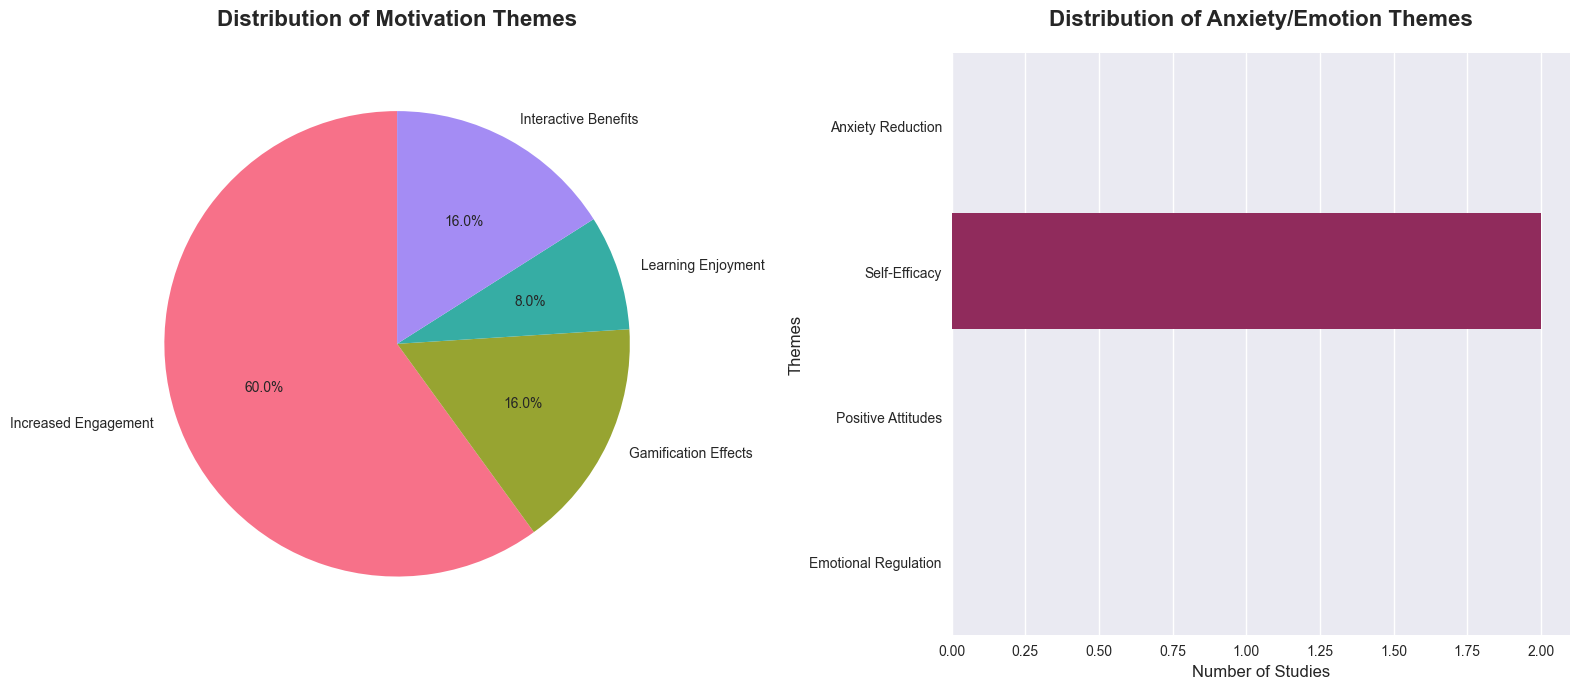


Motivation Theme Counts:
{'Increased Engagement': 15, 'Gamification Effects': 4, 'Learning Enjoyment': 2, 'Interactive Benefits': 4}

Anxiety/Emotion Theme Counts:
{'Anxiety Reduction': 0, 'Self-Efficacy': 2, 'Positive Attitudes': 0, 'Emotional Regulation': 0}

--- 2. Performing Effect Size Analysis ---
Extracted 8 effect size values related to affective outcomes.


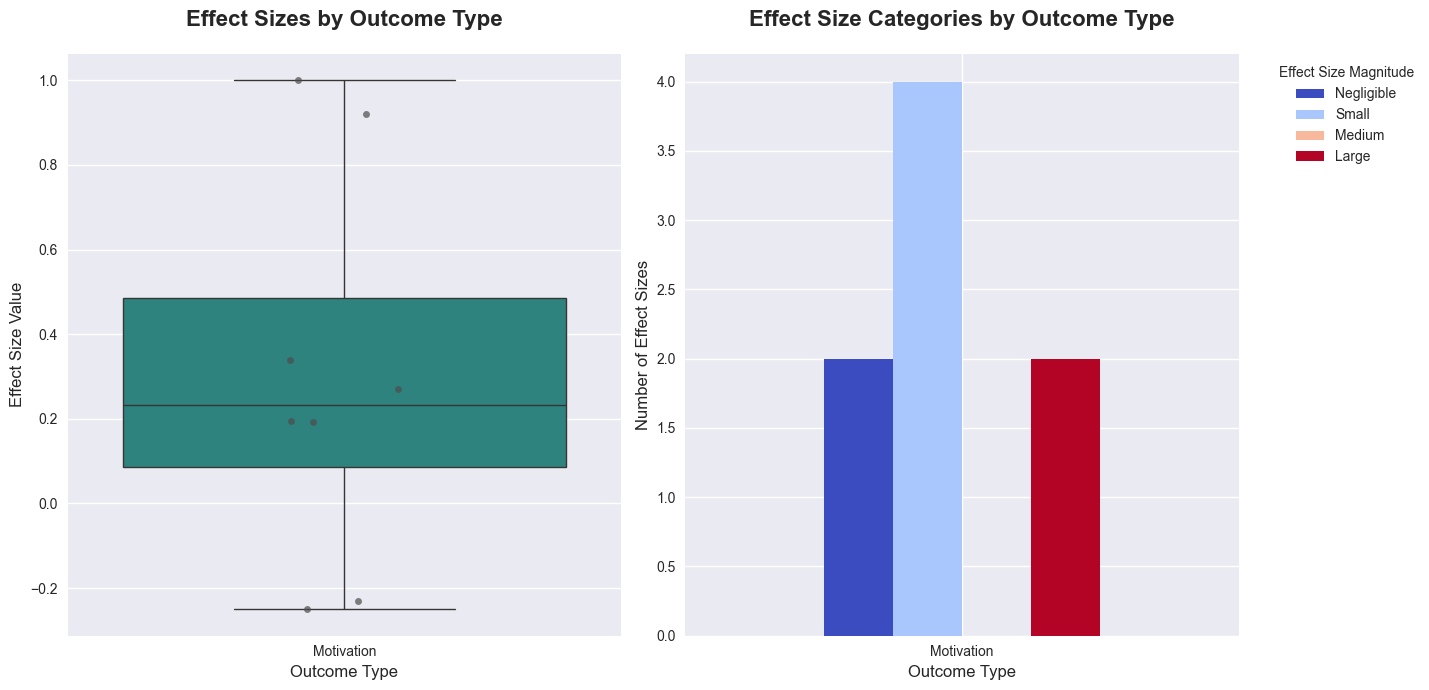


Effect Size Statistics:
            count   mean   std   min    25%    50%    75%  max
type                                                          
Motivation    8.0  0.305  0.46 -0.25  0.087  0.232  0.485  1.0

Effect Size Category Counts:
category    Negligible  Small  Medium  Large
type                                        
Motivation           2      4       0      2

--- 3. Performing Text Analysis and Word Clouds ---


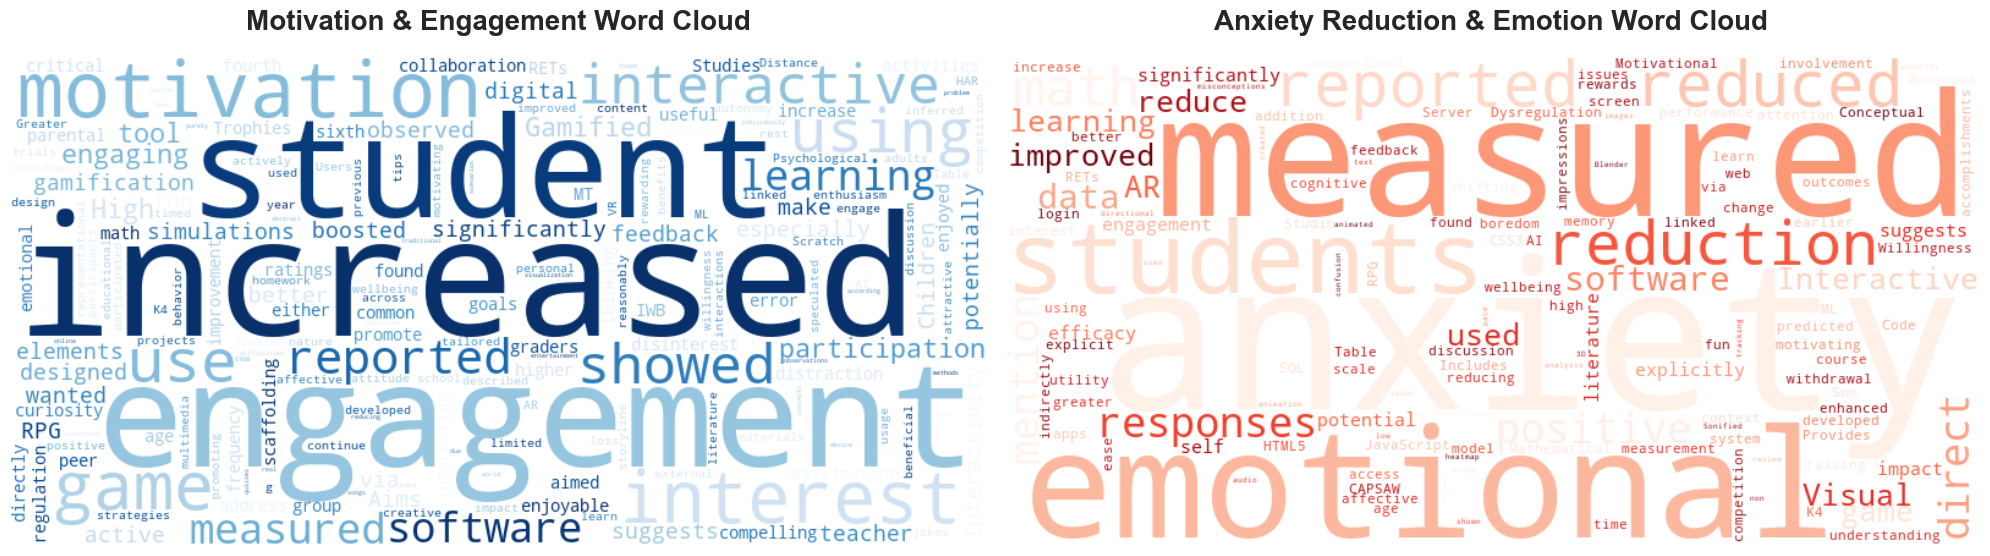


--- 4. Performing Sentiment Analysis ---


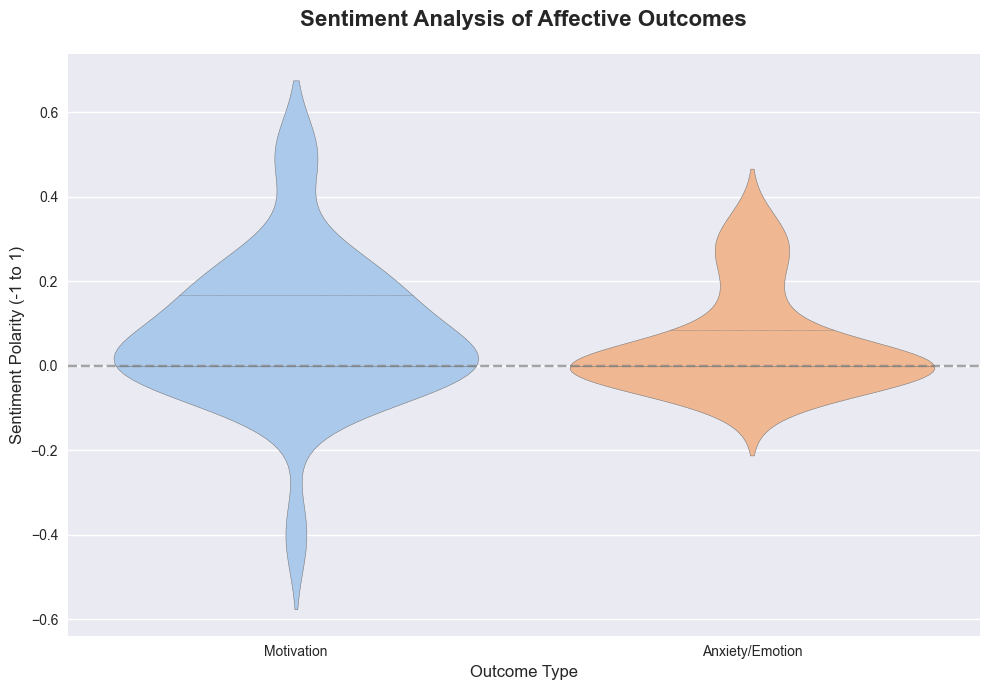


Sentiment Analysis Summary:
       Motivation  Anxiety/Emotion
count      29.000           26.000
mean        0.081            0.055
std         0.172            0.117
min        -0.400           -0.090
25%         0.000            0.000
50%         0.000            0.000
75%         0.167            0.085
max         0.500            0.345

--- 5. Performing Outcome Frequency Analysis ---


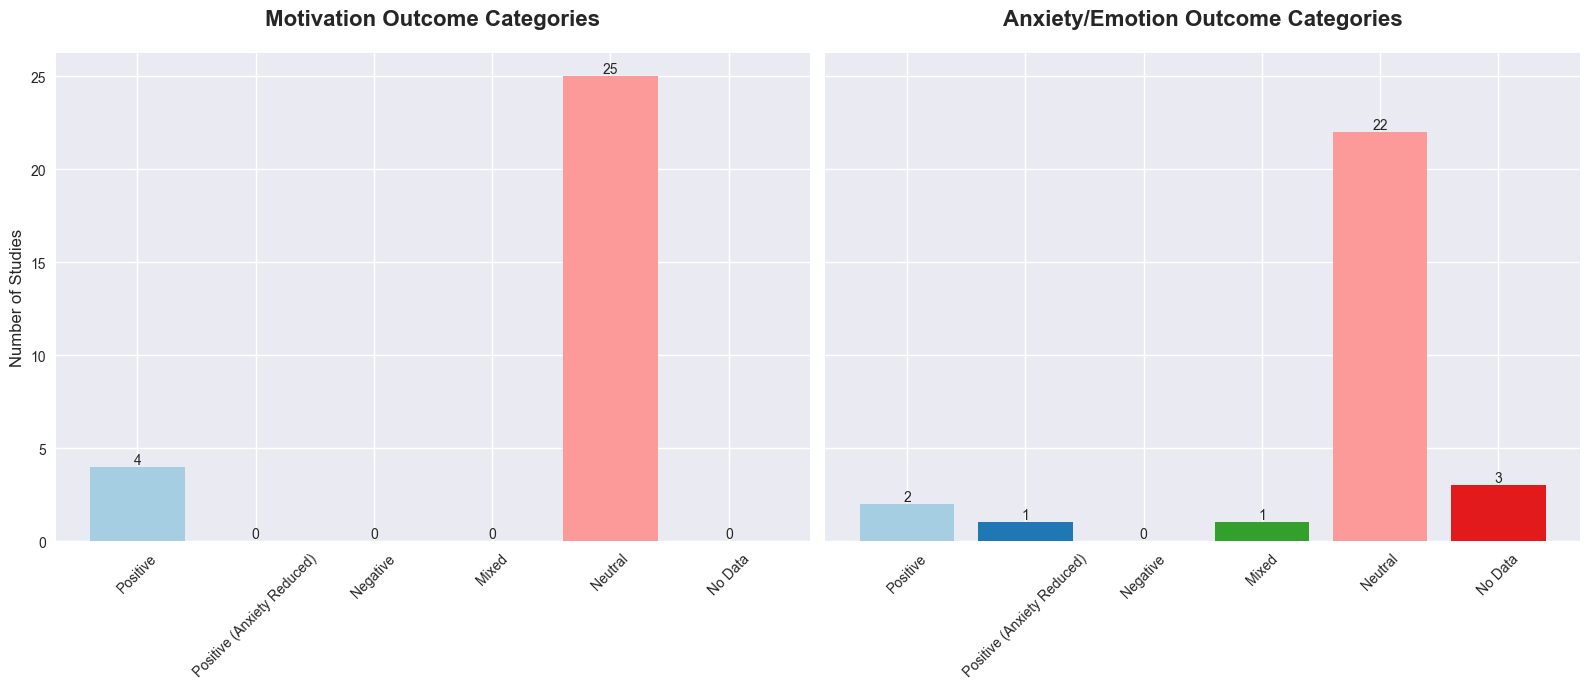


Motivation Outcome Counts:
motivation_outcome
Positive                       4
Positive (Anxiety Reduced)     0
Negative                       0
Mixed                          0
Neutral                       25
No Data                        0
Name: count, dtype: int64

Anxiety/Emotion Outcome Counts:
anxiety_outcome
Positive                       2
Positive (Anxiety Reduced)     1
Negative                       0
Mixed                          1
Neutral                       22
No Data                        3
Name: count, dtype: int64

--- 6. Performing Timeline Analysis ---


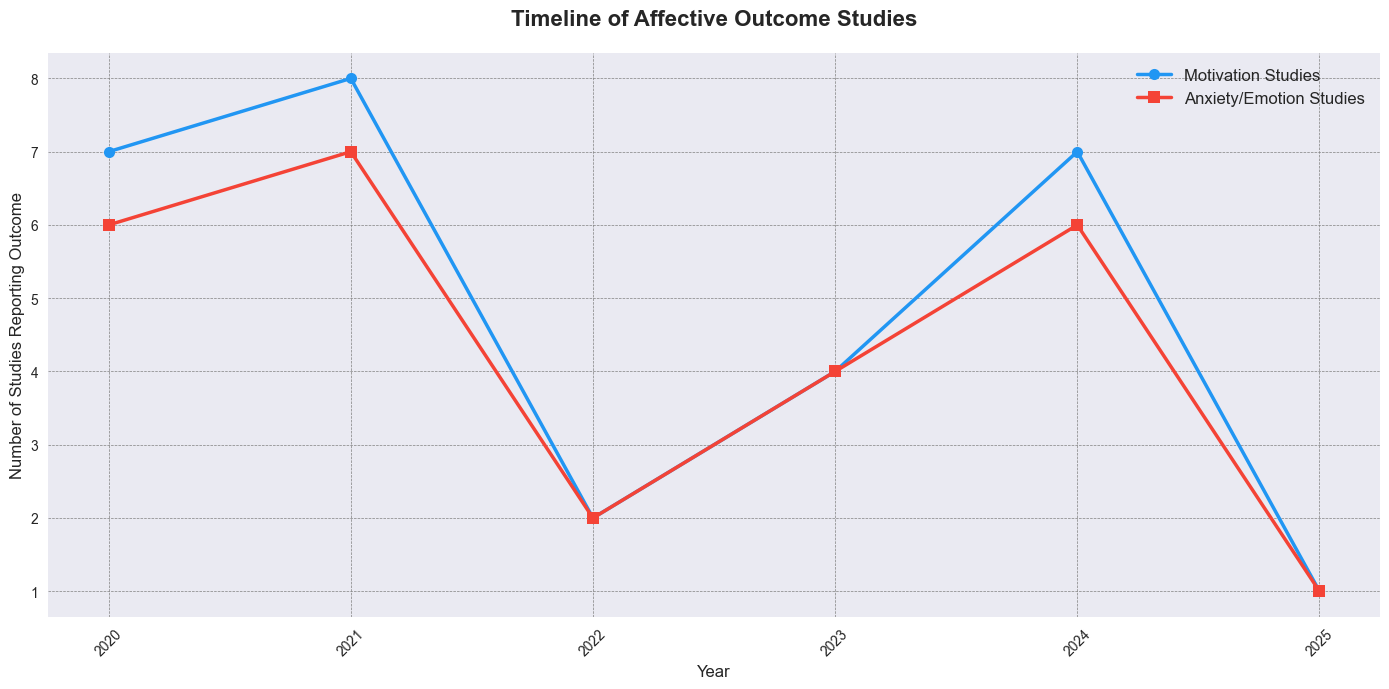


Studies per Year Reporting Affective Outcomes:
      Motivation_Studies  Anxiety_Studies
Year                                     
2020                   7                6
2021                   8                7
2022                   2                2
2023                   4                4
2024                   7                6
2025                   1                1


In [17]:
# 2. Perform Analyses (Store results)
mot_counts_res, anx_counts_res = perform_thematic_analysis(df_main)
effect_df_res = perform_effect_size_analysis(df_main)
perform_text_analysis_wordclouds(df_main) # Will skip if library not found
df_main = perform_sentiment_analysis(df_main) # Update df
df_main = perform_outcome_frequency_analysis(df_main) # Update df
perform_timeline_analysis(df_main)

In [18]:
# 7. Generate Summary Report using stored results
generate_summary_report(df_main, mot_counts_res, anx_counts_res, effect_df_res)


      SUMMARY REPORT - AFFECTIVE OUTCOMES ANALYSIS
Total studies in dataset: 29

1. THEMATIC ANALYSIS RESULTS
------------------------------
Motivation Themes Distribution:
  Increased Engagement: 15 mentions (60.0%)
  Gamification Effects: 4 mentions (16.0%)
  Interactive Benefits: 4 mentions (16.0%)
  Learning Enjoyment: 2 mentions (8.0%)

Anxiety/Emotion Themes Distribution:
  Self-Efficacy: 2 mentions (100.0%)

2. EFFECT SIZE ANALYSIS
------------------------------
Total effect sizes extracted related to affective outcomes: 8
  Mean effect size: 0.305
  Median effect size: 0.233
  Effect size range: -0.250 to 1.000

  Effect Sizes by Type:
            count   mean   std   min    25%    50%    75%  max
type                                                          
Motivation    8.0  0.305  0.46 -0.25  0.087  0.232  0.485  1.0

  Effect Sizes by Magnitude Category:
category
Negligible    2
Small         4
Medium        0
Large         2
Name: count, dtype: int32

3. SENTIMENT ANALYS